# XMG Case Study

Submitted by: Robin Warner

Date: 2021-08-15

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import statsmodels.api as sm
import w_risk_kit as wr

import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Question 1

### The returns provided with this questionnaire relate to four funds. Assume Funds A, B, and C are the current (equally weighted) constituents of your portfolio. You are investigating whether or not to invest in Fund D.

#### SETUP    

A few notes before we get started. In order to set up the data for this question, there were a few cleansing and manipulation steps that needed to be undertaken. They were:

- Downfilled N/As (i.e. used previous available value) in the data for the Nikkei, US Corp HY, and US Corp IG indices
- Translated all levels for the reference indices into returns
- Converted dataset into CSV
- Aggregated the daily return series into monthly returns so as to allow for a more 'i.i.d.' dataset (i.e. remove autocorrelation of daily returns)
    
The first two of the three steps were undertaken in the raw dataset and then converted to CSV. This CSV was made available through the wr.get_q1_returns() function. The monthly aggregation part is handled in the following code snippet:

In [3]:
q1DlyRetDf = wr.get_q1_returns()
q1MthRetDf = wr.calc_mth_returns(q1DlyRetDf)

The w_risk_kit library referenced throughout this notebook does most of the heavy lifting in terms of calculations. It's a custom library using some methods I've come across to solve common problems. Happy to walk through that part of the code as well.

### a. Fund D in Isolation: Assuming this fund employs a global macro strategy, evaluate the manager using the provided reference indices. Is there other indices or assets you would want to consider? Perform calculations and discuss.

#### OVERVIEW

To begin our analysis of FUND D, the table below summarizes the monthly returns series in a standardized format. A risk free rate of 1% is assumed.

In [4]:
bmCols = ['S&P 500 INDEX',
          'CBOE SPX VOLATILITY INDX',
          'FTSE 100 INDEX',
          'Euro Stoxx 50 Pr',
          'NIKKEI 225',
          'ISHARES MSCI EMERGING MARKET',
          'DOLLAR INDEX SPOT',
          'US CORP HY INDEX',
          'US CORP IG INDEX',
          'TREND FOLLOWING INDEX']
ret_summary = wr.std_distr_analysis(q1MthRetDf[['FUND D']+bmCols], 12, 0.01)
ret_summary

,FUND D,S&P 500 INDEX,CBOE SPX VOLATILITY INDX,FTSE 100 INDEX,Euro Stoxx 50 Pr,NIKKEI 225,ISHARES MSCI EMERGING MARKET,DOLLAR INDEX SPOT,US CORP HY INDEX,US CORP IG INDEX,TREND FOLLOWING INDEX
Annualized Return,0.012657,0.11295,-0.028455,0.037783,0.044142,0.152851,-0.043757,0.055751,0.053053,0.028595,0.028857
Annualized Volatility,0.099119,0.101082,0.974221,0.104327,0.148375,0.175164,0.157573,0.069816,0.057017,0.041802,0.104526
Skewness,0.768102,-0.064331,2.086988,-0.334919,-0.012155,-0.384213,0.348599,-0.01057,-0.008613,-0.357299,0.19679
Kurtosis,4.418681,3.127444,10.984683,2.790464,2.622761,2.861241,3.127903,2.474188,2.764954,3.355598,2.133133
Is Normal,True,True,False,True,True,True,True,True,True,True,True
Sharpe Ratio,0.026522,1.009229,-0.039394,0.263851,0.22796,0.808082,-0.338112,0.64935,0.748211,0.440784,0.178727
Gaussian VaR (95%),0.045138,0.038133,0.42904,0.045488,0.065227,0.069141,0.076766,0.028081,0.022347,0.017222,0.046306
Cornish-Fisher VaR (95%),0.03783,0.038584,0.196289,0.048389,0.065696,0.074608,0.072086,0.028353,0.022464,0.01832,0.045136
Monthly Historic VaR (95%),0.041817,0.033869,0.329564,0.04765,0.066793,0.083638,0.072773,0.024931,0.024454,0.0202,0.038962
Monthly Historic CVaR (95%),0.053831,0.049633,0.361304,0.06305,0.076052,0.088638,0.084097,0.033835,0.026162,0.025814,0.044281


FUND D's monthly return distribution (as seen in the above) shows slight skewness and excess kurtosis relative to a normal distribution. However, as per the Jacque-Berque normality test, it does not significantly deviate from normal (results from the test are stored in the 'Is Normal' row).

Compared with the S&P 500 index, the fund has a lower sharpe ratio (0.02 vs. 1.01; driven by its much lower annualized return) and more severe tails (when looking at VaR). Its max drawdown is also more severe at -20.6% vs. the S&P's -8.9%.

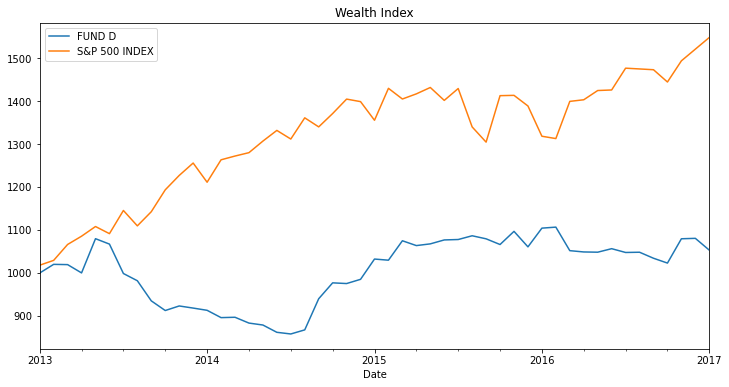

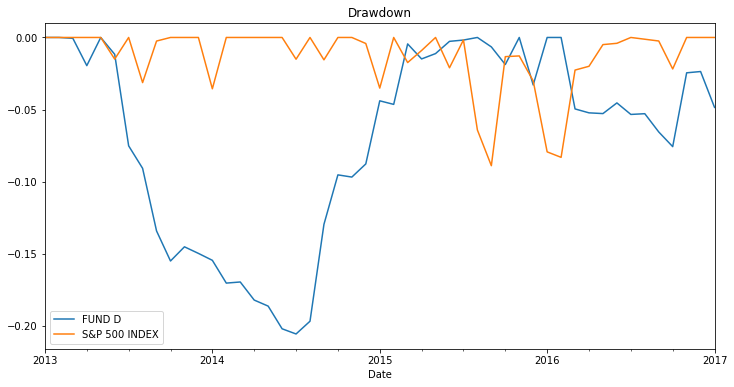

In [5]:
ts1 = (q1MthRetDf.aggregate(lambda col: wr.drawdown(col)['Wealth'])[['FUND D',
                                                                    'S&P 500 INDEX']]).plot(title = 'Wealth Index', 
                                                                                               figsize=(12,6))
ts2 = (q1MthRetDf.aggregate(lambda col: wr.drawdown(col)['Drawdown'])[['FUND D',
                                                                      'S&P 500 INDEX']]).plot(title = 'Drawdown', 
                                                                                               figsize=(12,6))


#### FACTOR ANALYSIS

Below, a multi-linear regression is done between FUND D and the benchmarks. The resulting model is a modest fit as denoted by the 0.564 adjusted R-squared value.

In [6]:
X = q1MthRetDf[bmCols]
X = sm.add_constant(X)
y = q1MthRetDf['FUND D']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 FUND D   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     7.206
Date:                Sun, 15 Aug 2021   Prob (F-statistic):           3.04e-06
Time:                        17:33:12   Log-Likelihood:                 131.17
No. Observations:                  49   AIC:                            -240.3
Df Residuals:                      38   BIC:                            -219.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.0020      0.004     -0.536      0.595      -0.009       0.005
S&P 500 INDEX                   -0.1128      0.228     -0.494      0.624      -0.575       0.349
CBOE SPX VOLATILITY INDX         0.0160      0.016      0.979      0.334      -0.017       0.049
FTSE 100 INDEX                  -0.1619      0.154     -1.050      0.301      -0.474       0.150
Euro Stoxx 50 Pr                -0.0170      0.116     -0.146      0.884      -0.252       0.218
NIKKEI 225                      -0.1357      0.087     -1.558      0.128      -0.312       0.041
ISHARES MSCI EMERGING MARKET     0.0429      0.109      0.392      0.697      -0.179       0.265
DOLLAR INDEX SPOT                0.9583      0.189      5.058      0.000       0.575       1.342
US CORP HY INDEX                 1.0405      0.394      2.638      0.012       0.242       1.839
US CORP IG INDEX                -1.5971      0.448     -3.567      0.001      -2.504      -0.691
TREND FOLLOWING INDEX            0.4548      0.140      3.243      0.002       0.171       0.739
==============================================================================
Omnibus:                        5.269   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                4.192
Skew:                           0.552   Prob(JB):                        0.123
Kurtosis:                       3.914   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results above show that FUND D has significant positive exposure to the DOLLAR INDEX SPOT, the US CORP HY INDEX,
and the TREND FOLLOWING INDEX, but significant negative exposure to the US CORP IG INDEX. This is indicative of a Global Macro manager, as it indicates exposure to macro-economic variables such as interest rates and currency movements, as well as commodity exposure (as assumed from the positive exposure to the TREND FOLLOWING INDEX). 

Of note is the absence of a government rates factor in the analysis. Given the opposite coefficient signs between the CORP IG and HY series, as well as the negative correlation of FUND D with the two series (as seen in the correlation chart below), the model may be trying to isolate a rates factor (as well as a credit risk factor). Further research is merited.

FUND D has no significant exposure to any of the equity indices (as denoted by the coefficients and p-values of those coefficients).

<AxesSubplot:title={'center':'Correlation with FUND D'}>

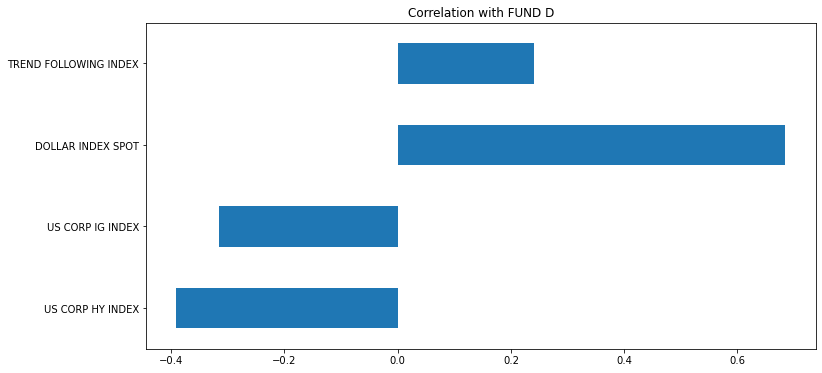

In [7]:
sigBmCols = ['US CORP HY INDEX',
             'US CORP IG INDEX',
             'DOLLAR INDEX SPOT',
             'TREND FOLLOWING INDEX']

corrFundD = pd.DataFrame(q1MthRetDf[['FUND D']+sigBmCols].corr()['FUND D']).drop('FUND D')
corrFundD.plot.barh(title='Correlation with FUND D', figsize=(12,6),legend=False)

### b. Portfolio Construction and Additivity: Provide two considerations one could use to evaluate the additivity of Fund D to the portfolio and how to combine the 4 funds. Discuss pros and cons and show calculations if necessary.

#### OVERVIEW
The following bit of code sets up the dataset we'll be using for portfolio construction and optimization. The first bit calculates the returns of the equally weighted portfolio containing funds A through C. Then this returns series, along with the return series of the individual funds, is combined into a single dataframe named pfRets.

In [9]:
funds = ['FUND A', 'FUND B', 'FUND C', 'FUND D']

currPfFunds = ['FUND A', 'FUND B', 'FUND C']
currPfFundRets = q1MthRetDf[currPfFunds]
currPfWgts = np.repeat(1/len(currPfFunds), len(currPfFunds))
currPfRets = pd.DataFrame(data= currPfFundRets @ currPfWgts, 
                          columns=['CURRENT PF'])
currPfRets = pd.concat([currPfFundRets,currPfRets], axis=1)

fundDRets = q1MthRetDf['FUND D']
fundDRets.round(4).head()

pfRets = pd.concat([currPfRets,fundDRets], axis=1)

pfRets.round(4).head()

,FUND A,FUND B,FUND C,CURRENT PF,FUND D
Date,,,,,
2013-01,0.0030,-0.0064,-0.0027,-0.0020,-0.0005
2013-02,0.0050,0.0062,-0.0073,0.0013,0.0201
2013-03,0.0109,0.0166,0.0317,0.0198,-0.0006
2013-04,0.0147,-0.0050,0.0098,0.0065,-0.0190
2013-05,0.0222,0.0280,-0.0004,0.0166,0.0797


In [10]:
wr.std_distr_analysis(pfRets,12,0.01)

,FUND A,FUND B,FUND C,CURRENT PF,FUND D
Annualized Return,0.074305,0.049398,0.06896,0.065914,0.012657
Annualized Volatility,0.039473,0.034707,0.111886,0.041467,0.099119
Skewness,-0.446411,-0.189445,-0.022223,-0.50585,0.768102
Kurtosis,3.88616,3.476143,3.664886,3.759653,4.418681
Is Normal,True,True,True,True,True
Sharpe Ratio,1.614313,1.124854,0.522142,1.336168,0.026522
Gaussian VaR (95%),0.012497,0.012236,0.0465,0.014084,0.045138
Cornish-Fisher VaR (95%),0.013684,0.012668,0.046273,0.015549,0.03783
Monthly Historic VaR (95%),0.013471,0.012058,0.05754,0.019753,0.041817
Monthly Historic CVaR (95%),0.02073,0.017461,0.062863,0.022441,0.053831


#### MEAN-VARIANCE APPROACH

Following the standard MPT approach to portfolio construction, naturally the first attempt at adding FUND D to the portfolio would be through mean-variance optimization.

The analysis below attempts to find the optimum addition of FUND D to the portfolio using two methods:
- Keep current portfolio the same (i.e. equal weights for funds A through C) and find the optimum (as defined by maximum sharpe ratio) combination of current portfolio and FUND D
- Allow current portfolio weights to shift (meaning weights between funds A through C can change), and find the optimum combination of all funds

##### Assumptions
The analysis uses the following assumptions:
- Expected returns of the funds are given by their ex-post annualized return
- Expected volatility is given by the ex-post covariance matrix
- A risk free rate of 1% is used

##### Method 1: Find the optimum combination of current portfolio and FUND D

,Weight
FUND D,0.0
CURRENT PF,1.0


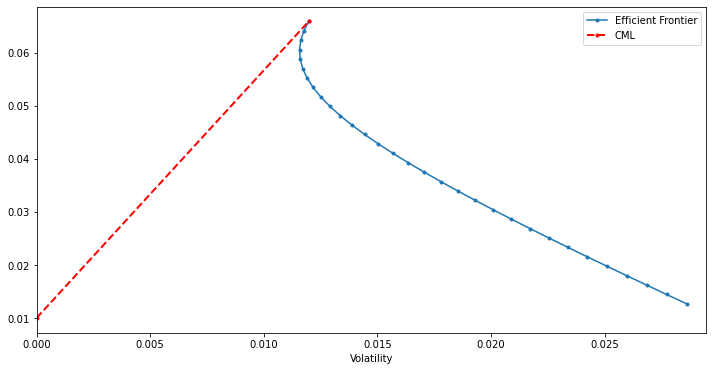

In [11]:
er = wr.annualize_rets(pfRets, 12)
cov = pfRets.cov()
l = ['FUND D', 'CURRENT PF']
riskfree_rate = 0.01

ax = wr.plot_ef(31, er[l], cov.loc[l,l], 
           show_cml=True, 
           riskfree_rate=riskfree_rate)

pd.DataFrame(wr.msr(riskfree_rate,er[l],cov.loc[l,l]).round(4),
             index=er[l].index,
             columns=['Weight'])

##### Method 2: Find the optimum combination of all funds

,Weight
FUND A,0.5546
FUND B,0.3782
FUND C,0.0673
FUND D,0.0000


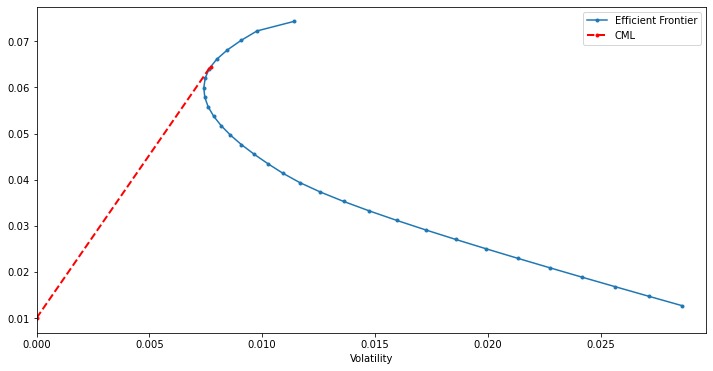

In [12]:
er = wr.annualize_rets(pfRets, 12)
cov = pfRets.cov()
l = funds
riskfree_rate = 0.01

wr.plot_ef(31, er[l], cov.loc[l,l], 
           show_cml=True, 
           riskfree_rate=riskfree_rate)
pd.DataFrame(wr.msr(riskfree_rate,er[l],cov.loc[l,l]).round(4),
             index=er[l].index,
             columns=['Weight'])

##### Results
The results state there is no justification to add any amount of Fund D to the portfolio when using a mean-variance optimization approach. However it's important to note that such an approach is highly sensitive to expected return, and covariance estimates (as well as the risk free rate). As stated in the assumption section, our method for determining these values was incredibly naive, relying on ex-post values as parameters. 

An alternative approach would be to limit estimation error by forgoing estimating values for expected returns, and instead rely solely on providing covariance estimates (arguably the easier of the two parameters to estimate). In such an approach it may still be worth adding Fund D to the portfolio so as to target global minimum variance, a guaranteed point on the efficient frontier. Below, we look at this method.

##### Method 1: Find minimum variance portfolio with combination of current portfolio and FUND D

In [13]:
er = wr.annualize_rets(pfRets, 12)
cov = pfRets.cov()
l = ['FUND D', 'CURRENT PF']

opt_wgts = wr.optimal_weights(31,er[l],cov.loc[l,l])
ow = pd.DataFrame(opt_wgts,
                  columns = l)
v = pd.DataFrame([wr.portfolio_vol(w, cov.loc[l,l]) for w in opt_wgts], 
                 columns = ['Vol'])
pfVolCombo = (pd.concat([ow,v], axis=1)).round(4)

pd.DataFrame(pfVolCombo.loc[pfVolCombo['Vol'].idxmin()])

,26
FUND D,0.1333
CURRENT PF,0.8667
Vol,0.0116


##### Method 2: Find minimum variance portfolio by allowing all fund weights to change

In [14]:
er = wr.annualize_rets(pfRets, 12)
cov = pfRets.cov()
l = funds

opt_wgts = wr.optimal_weights(31,er[l],cov.loc[l,l])
ow = pd.DataFrame(opt_wgts,
                  columns = l)
v = pd.DataFrame([wr.portfolio_vol(w, cov.loc[l,l]) for w in opt_wgts], 
                 columns = ['Vol'])
pfVolCombo = (pd.concat([ow,v], axis=1)).round(4)

pd.DataFrame(pfVolCombo.loc[pfVolCombo['Vol'].idxmin()])

,23
FUND A,0.4322
FUND B,0.4933
FUND C,0.0444
FUND D,0.0302
Vol,0.0074


These results show that there is reason to hold even a slight amount (as small as 3%) of FUND D in the portfolio in order to target minimum volatility. This is not surprising, given that FUND D's correlation with the other funds is less than perfect.

In [15]:
pfRets.corr()

,FUND A,FUND B,FUND C,CURRENT PF,FUND D
FUND A,1.000000,0.025820,-0.121390,0.215334,-0.028114
FUND B,0.025820,1.000000,0.153948,0.425651,0.192671
FUND C,-0.121390,0.153948,1.000000,0.903838,0.124454
CURRENT PF,0.215334,0.425651,0.903838,1.000000,0.156769
FUND D,-0.028114,0.192671,0.124454,0.156769,1.000000


#### TAIL RISK IMPROVEMENT APPROACH

Continuing with the minimization idea, instead of minimizing volatility one could choose to mimimize any risk measure in order to determine an appropriate amount to allocate to FUND D. Below we look at minimizing tail risk measures as a solution.

##### Method 1: Minimizing portfolio tail risk with combination of current portfolio and FUND D

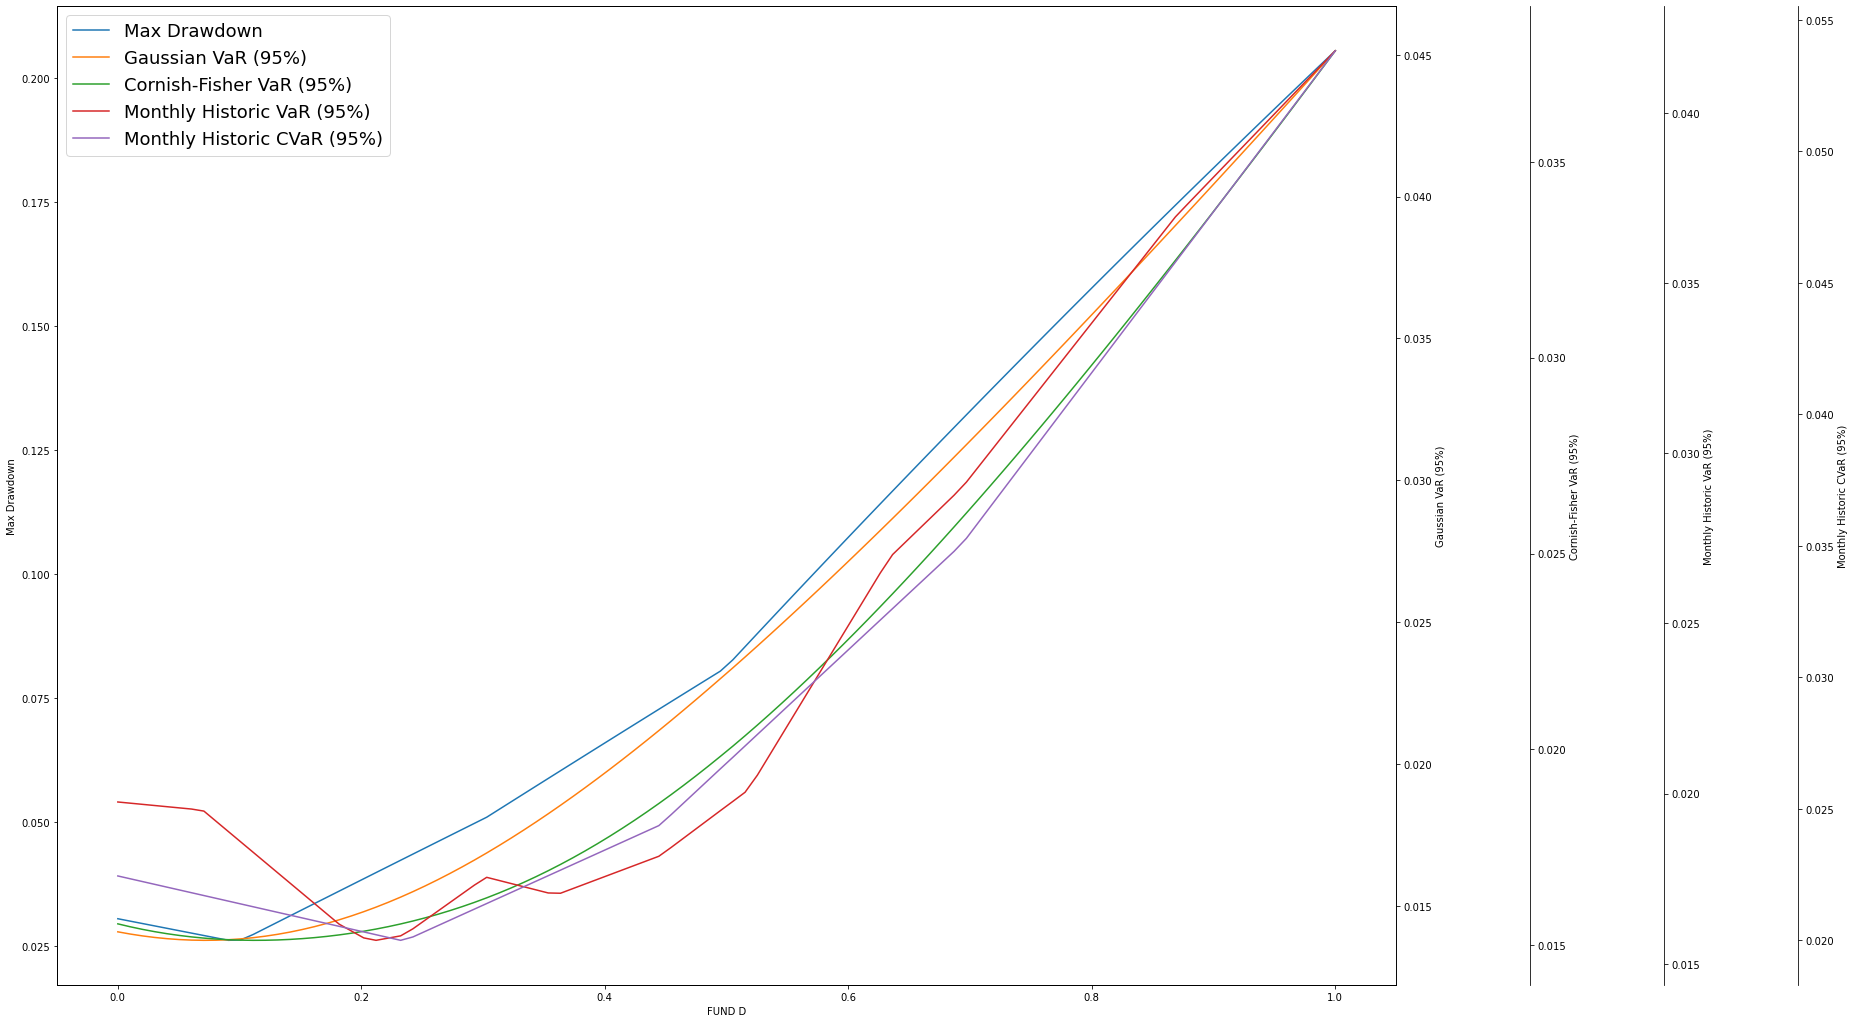

In [16]:
er = wr.annualize_rets(pfRets, 12)
cov = pfRets.cov()
l = ['FUND D', 'CURRENT PF']

tailRiskMeasures = ['Max Drawdown',
                    'Gaussian VaR (95%)',
                    'Cornish-Fisher VaR (95%)',
                    'Monthly Historic VaR (95%)',
                    'Monthly Historic CVaR (95%)']

opt_wgts = wr.optimal_weights(100, er[l], cov.loc[l,l])
ow = pd.DataFrame(opt_wgts,columns = l)
sd = wr.std_distr_analysis(pd.DataFrame([pfRets[l] @ w for w in opt_wgts]).T,12,0.01).T
pfStdDistrCombo = (pd.concat([ow,sd], axis=1)).round(4)
pfStdDistrCombo['Max Drawdown'] = pfStdDistrCombo['Max Drawdown']*-1
pfStdDistrCombo.index = pfStdDistrCombo['FUND D']

ax = wr.plot_multi(pfStdDistrCombo[tailRiskMeasures], figsize=(24,18))

##### Method 2: Minimizing portfolio tail risk by allowing all fund weights to change

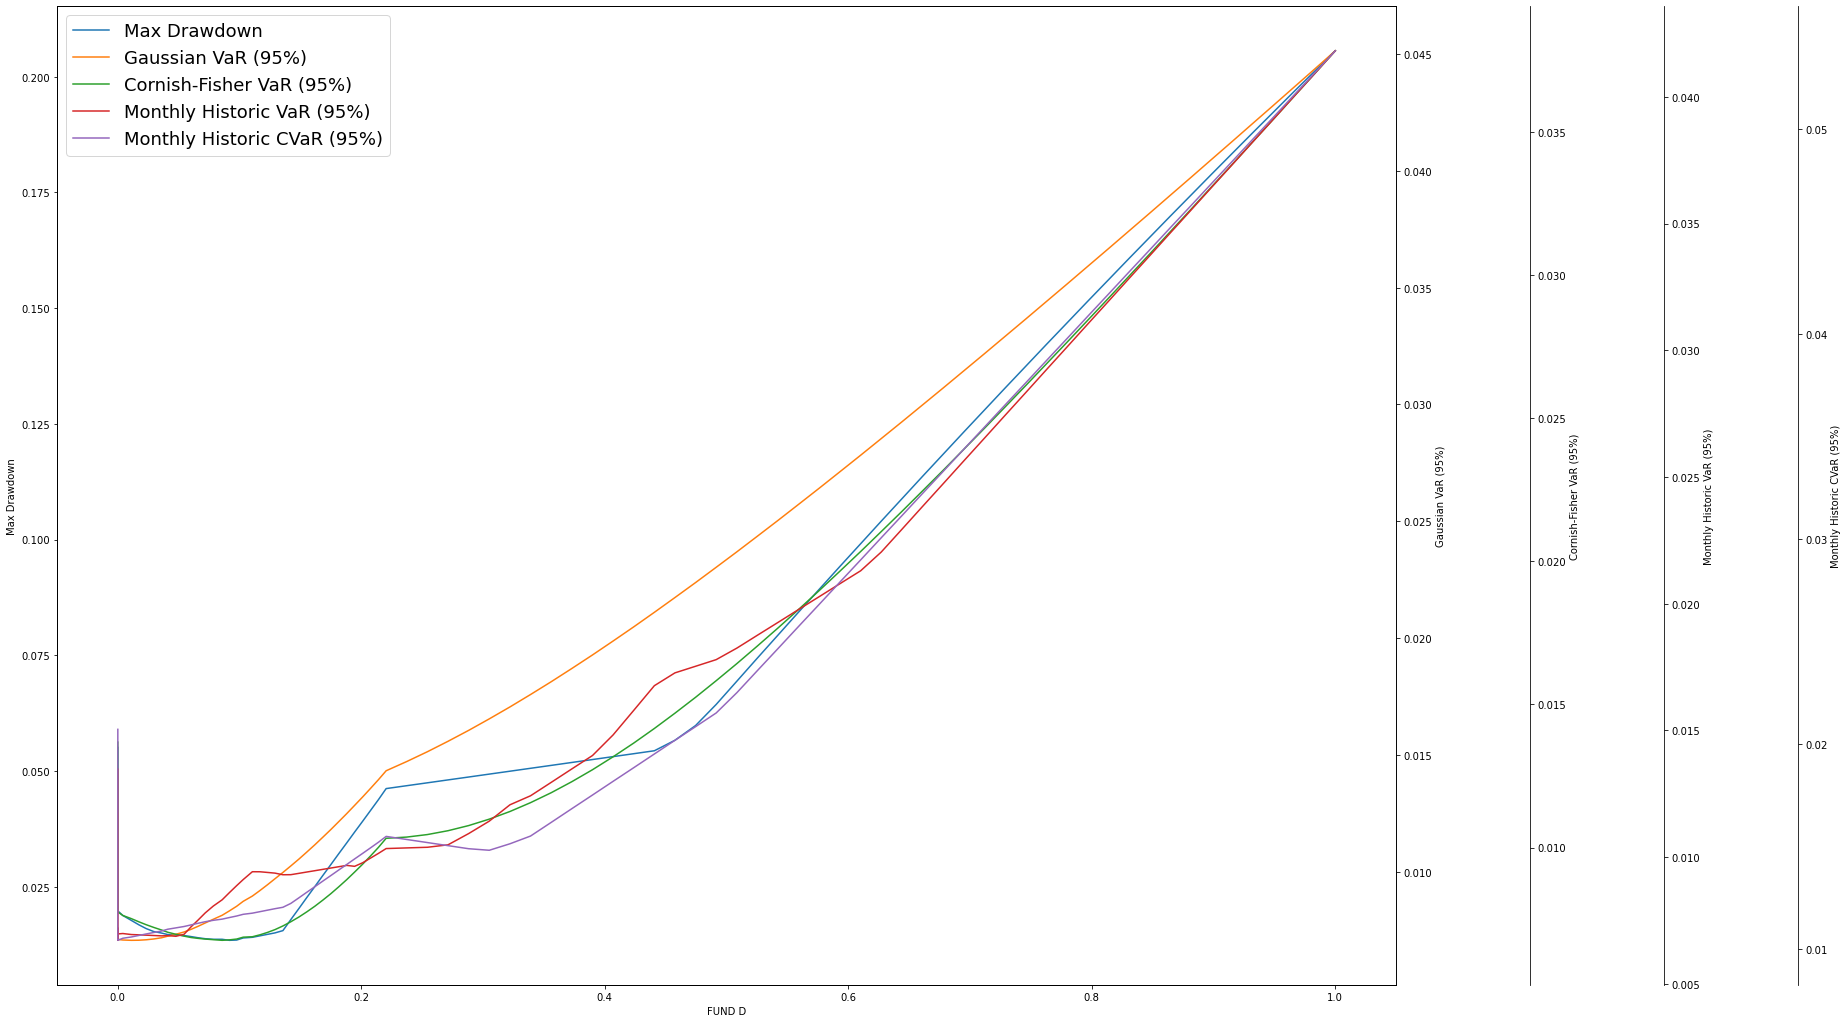

In [17]:
er = wr.annualize_rets(pfRets, 12)
cov = pfRets.cov()
l = funds

tailRiskMeasures = ['Max Drawdown',
                    'Gaussian VaR (95%)',
                    'Cornish-Fisher VaR (95%)',
                    'Monthly Historic VaR (95%)',
                    'Monthly Historic CVaR (95%)']

opt_wgts = wr.optimal_weights(100, er[l], cov.loc[l,l])
ow = pd.DataFrame(opt_wgts,columns = l)
sd = wr.std_distr_analysis(pd.DataFrame([pfRets[l] @ w for w in opt_wgts]).T,12,0.01).T
pfStdDistrCombo = (pd.concat([ow,sd], axis=1)).round(4)
pfStdDistrCombo['Max Drawdown'] = pfStdDistrCombo['Max Drawdown']*-1
pfStdDistrCombo.index = pfStdDistrCombo['FUND D']

ax = wr.plot_multi(pfStdDistrCombo[tailRiskMeasures], figsize=(24,18))

##### Results
Looking at the charts above (with the x-axis showing the amount of weight to allocate to FUND D), we see that allocating somewhere between ~5% to ~20% FUND D would be appropriate (depending on the measure one is most focused on).

## Question 2

### Please describe any hedge fund strategy of your choice. Your discussion may include (but doesn’t have to):


 - What are the merits of this strategy? 
 - In which market environments do such strategies perform best? 
 - What are the main risks? 
 - When selecting a manager employing this strategy, what are some of the considerations? 
 - What metrics would you monitor?

#### Strategy: EQUITY MARKET NEUTRAL

##### What are the merits of this strategy?
Equity market neutral strategies attempt to balance the systematic risk of their long book with their short book, leaving behind exposure to their main alpha generation engine (typically security selection skill). As this fund is now, in theory, neutralized to the market Beta factor, it becomes an ideal alpha engine to port above a passive asset class benchmark. Thus, the strategy may 'enhance' the benchmark's return by providing exposure to an orthogonal risk factor, without bringing additional systematic risk.

##### In which market environments do such strategies perform best?
Periods of low volatility, where maintaining market neutrality is at its easiest.

##### What are the main risks? 
A big risk with equity market neutral strategies is gaining unwanted Beta exposure during periods of mass deleveraging. As markets tend to be at their most volatile during these periods, keeping a portfolio net-neutral is at its most difficult. The manager's ability to rebalance during such periods is key, and as such the liquidity of their books is very important.

##### When selecting a manager employing this strategy, what are some of the considerations?
- How do they measure the market factor exposure of a security and then subsequently hedge that Beta?
- How long of a track record does the fund have? Were there periods of deleveraging that they encountered? What was their Beta exposure in such periods?
- By what mechanisms are they able to increase/decrease their gross exposure (and thus their leverage), and how do they ensure that it stays neutral?
- What do they believe to be the premium they're capturing (ex. liquidity premium) after neutralizing market exposure?

##### What metrics would you monitor?
The following would be an ideal list of metrics to monitor:
- Rolling period betas and correlations with the equity markets we believe them to be neutral to.
- Net exposure and gross exposure though time.
- Days to liquidate for both the long and short book separately.
- VaR and tail measures of both books separately. 

## Question 3

###  Generate a backtest for a trend strategy using the attached total return commodity futures market data. Elaborate on the tools you used to generate the backtest and justify the choices you made for the strategy’s parameters. Discuss potential enhancements that could be considered given more time and resources.

#### SETUP    
    
Like question 1, the raw dataset for this question has been converted to CSV then made available through the wr.get_q3_lvls() function. This is handled in the following code snippet:

In [18]:
commLvls = wr.get_q3_lvls()

#### THE STRATEGY

The trend strategy I decided to employ is very simple: take two moving averages of different window lengths (in this example 10 days and 45 days), and when they cross that's the signal to trade. 

The direction of the trade is determined by how the shorter-window-moving-average crosses the longer-window-moving-average. If the shorter crosses from above, sell; if from below, buy.

The charts below demonstrate the strategy on the WTI crude oil series from 2015 onwards.

<AxesSubplot:title={'center':'Moving Averages'}, xlabel='Date'>

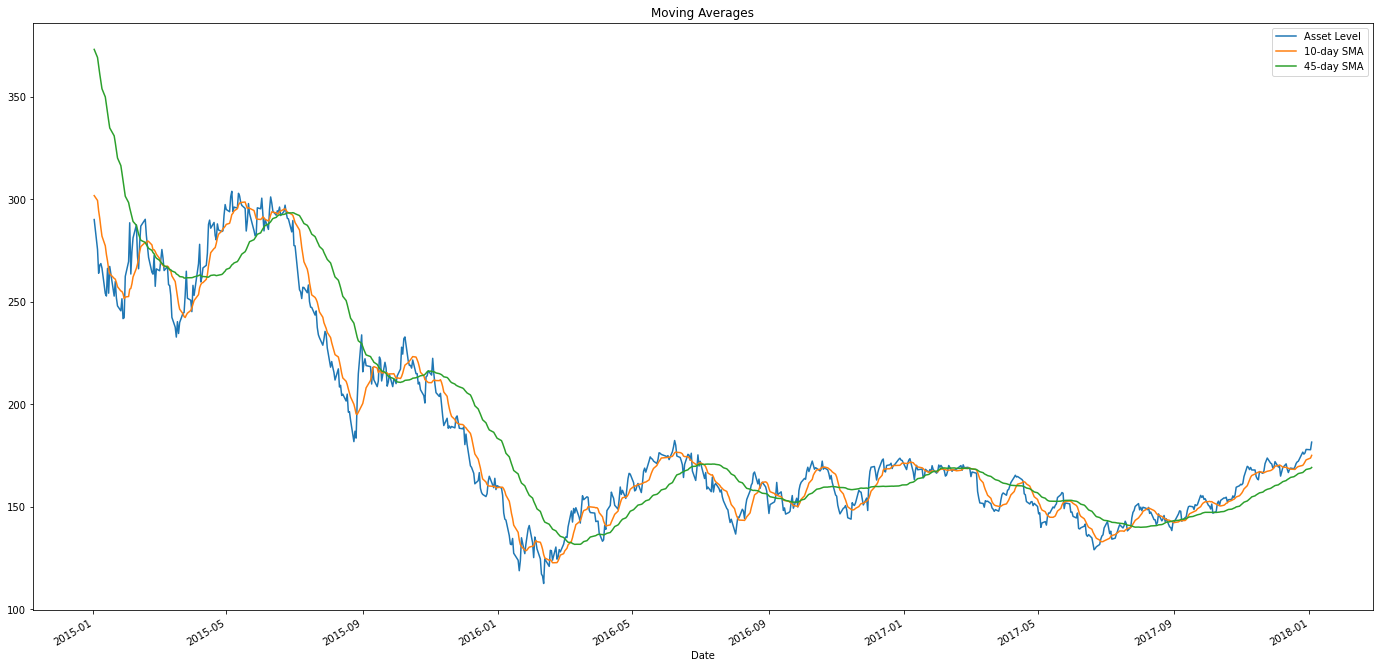

In [19]:
wtiCrudeOilTrendAnalysis = wr.trend_info(commLvls['WTI crude oil'])
wtiCrudeOilTrendAnalysis[['Asset Level','10-day SMA','45-day SMA']]['2015':].plot(figsize=(24,12), 
                                                                                           title="Moving Averages")

<AxesSubplot:title={'center':'Trade Signal (-1:Short, 1:Long)'}, xlabel='Date'>

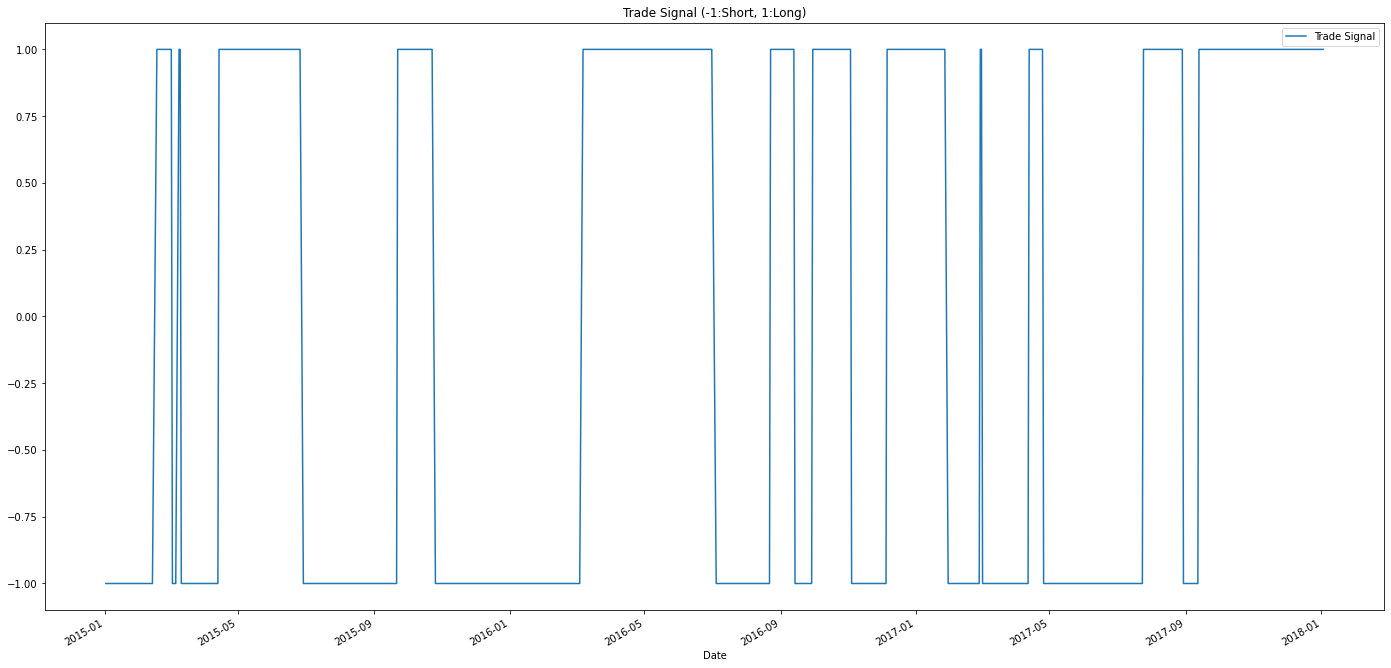

In [20]:
wtiCrudeOilTrendAnalysis[['Trade Signal']]['2015':].plot(figsize=(24,12),
                                                        title="Trade Signal (-1:Short, 1:Long)")

The trade signal and strategy return is processed and stored in a Pandas DataFrame with the wr.trend_info function. This DataFrame is then to be used for analysis and portfolio construction.

In [21]:
wtiCrudeOilTrendAnalysis.tail(10)

,Asset Level,Asset Returns,10-day SMA,45-day SMA,SMA Diff (10D - 45D),SMA Cross (10D - 45D),Trade Signal,Strategy Returns
Date,,,,,,,,
2017-12-19,169.4522,0.005942,168.12754,164.902242,3.225298,0.0,1.0,0.005942
2017-12-20,171.0125,0.009208,168.74253,165.277302,3.465228,0.0,1.0,0.009208
2017-12-21,171.8074,0.004648,169.22195,165.660167,3.561783,0.0,1.0,0.004648
2017-12-22,172.1312,0.001885,169.53523,166.099524,3.435706,0.0,1.0,0.001885
2017-12-26,176.5471,0.025654,170.10694,166.615322,3.491618,0.0,1.0,0.025654
2017-12-27,175.5756,-0.005503,170.83881,167.105587,3.733223,0.0,1.0,-0.005503
2017-12-28,176.1644,0.003354,171.79559,167.571469,4.224121,0.0,1.0,0.003354
2017-12-29,177.8719,0.009693,172.77887,168.094358,4.684512,0.0,1.0,0.009693
2018-01-02,177.7247,-0.000828,173.67383,168.583740,5.090090,0.0,1.0,-0.000828


#### SUMMARY

The table below compares the median monthly results of the strategy with a simple buy and hold strategy across all the commodity series. A risk free rate of 1% is assumed.

In [22]:
CommMthRets = wr.calc_mth_returns(commLvls.aggregate(lambda col: wr.trend_info(col)['Asset Returns']))
CommMthStratRets = wr.calc_mth_returns(commLvls.aggregate(lambda col: wr.trend_info(col)['Strategy Returns']))

medianMthRetsStats = pd.concat([(wr.std_distr_analysis(CommMthStratRets,12, 0.01).T.drop(['Is Normal',
                                                                                     'Maximum Date',
                                                                                     'Minimum Date',
                                                                                     'Max Drawdown Period End'],
                                                                                     axis=1)).median(),
                       wr.std_distr_analysis(CommMthRets,12, 0.01).T.drop(['Is Normal',
                                                                                'Maximum Date',
                                                                                'Minimum Date',
                                                                                'Max Drawdown Period End'],
                                                                                axis=1).median()],
                      axis = 1)
medianMthRetsStats.columns = ['Strategy Returns','Raw Commodity Returns']
medianMthRetsStats

,Strategy Returns,Raw Commodity Returns
Annualized Return,0.074558,0.017061
Annualized Volatility,0.295163,0.297545
Skewness,0.346268,-0.081611
Kurtosis,4.157159,3.654794
Sharpe Ratio,0.249451,0.025997
Gaussian VaR (95%),0.126129,0.135599
Cornish-Fisher VaR (95%),0.107331,0.129872
Monthly Historic VaR (95%),0.105779,0.129403
Monthly Historic CVaR (95%),0.153769,0.171473
Maximum,0.282486,0.274826


Looking at the individual series, the strategy modestly improves the raw commodity returns with the median sharpe ratio climbing 0.02 to 0.25. While this isn't anything amazing, the modest improvement from such a simple rule gives promise (particularly when optimized).

#### PORTFOLIO CONSTRUCTION AND OPTIMIZATION

Wrapping it all up, below we take the raw returns and strategy returns generated above and run them through the same mean-variance optimization used in question 1 to find the optimum portfolio as defined by maximum sharpe.

In [23]:
erStrat = wr.annualize_rets(CommMthStratRets,12)
covStrat = CommMthStratRets.cov()
wgtsStrat = wr.msr(0.01,erStrat,covStrat)
OptwgtsStrat = pd.DataFrame(wgtsStrat.round(4),
                            index=erStrat.index,
                            columns = ['Optimal Strategy Portfolio'])
optPortStratMthRet = wr.calc_mth_returns(pd.DataFrame(CommMthStratRets @ wgtsStrat,
                                                      columns=['Optimal Strategy Portfolio']))

erRaw = wr.annualize_rets(CommMthRets,12)
covRaw = CommMthRets.cov()
wgtsRaw = wr.msr(0.01,erRaw,covRaw)
OptwgtsRaw = pd.DataFrame(wgtsRaw.round(4),
                          index=erRaw.index,
                          columns = ['Optimal Raw Commodity Portfolio'])
optPortRawMthRet = wr.calc_mth_returns(pd.DataFrame(CommMthRets @ wgtsRaw,
                                                      columns=['Optimal Raw Commodity Portfolio']))

optPortWgt = pd.concat([OptwgtsStrat,OptwgtsRaw],axis=1)
optPortMthRet = pd.concat([optPortStratMthRet,optPortRawMthRet],axis=1)

In [24]:
wr.std_distr_analysis(optPortMthRet,12,0.01)

,Optimal Strategy Portfolio,Optimal Raw Commodity Portfolio
Annualized Return,0.14481,0.11362
Annualized Volatility,0.10362,0.135973
Skewness,0.492529,-0.54109
Kurtosis,5.265578,5.084466
Is Normal,False,False
Sharpe Ratio,1.289201,0.755115
Gaussian VaR (95%),0.037304,0.054615
Cornish-Fisher VaR (95%),0.031627,0.058775
Monthly Historic VaR (95%),0.032613,0.055061
Monthly Historic CVaR (95%),0.046963,0.086002


The results above show an improvement in sharpe from 0.76 to 1.29. More impressive, however, is the improvement in drawdown from -30.4% to -9.7%. Furthermore, as seen in the graph below, the Optimal Strategy Portfolio's weights are more diversified, spread out across 9 assets rather than the concentrated 5 asset portfolio of the raw commodity portfolio.

<AxesSubplot:>

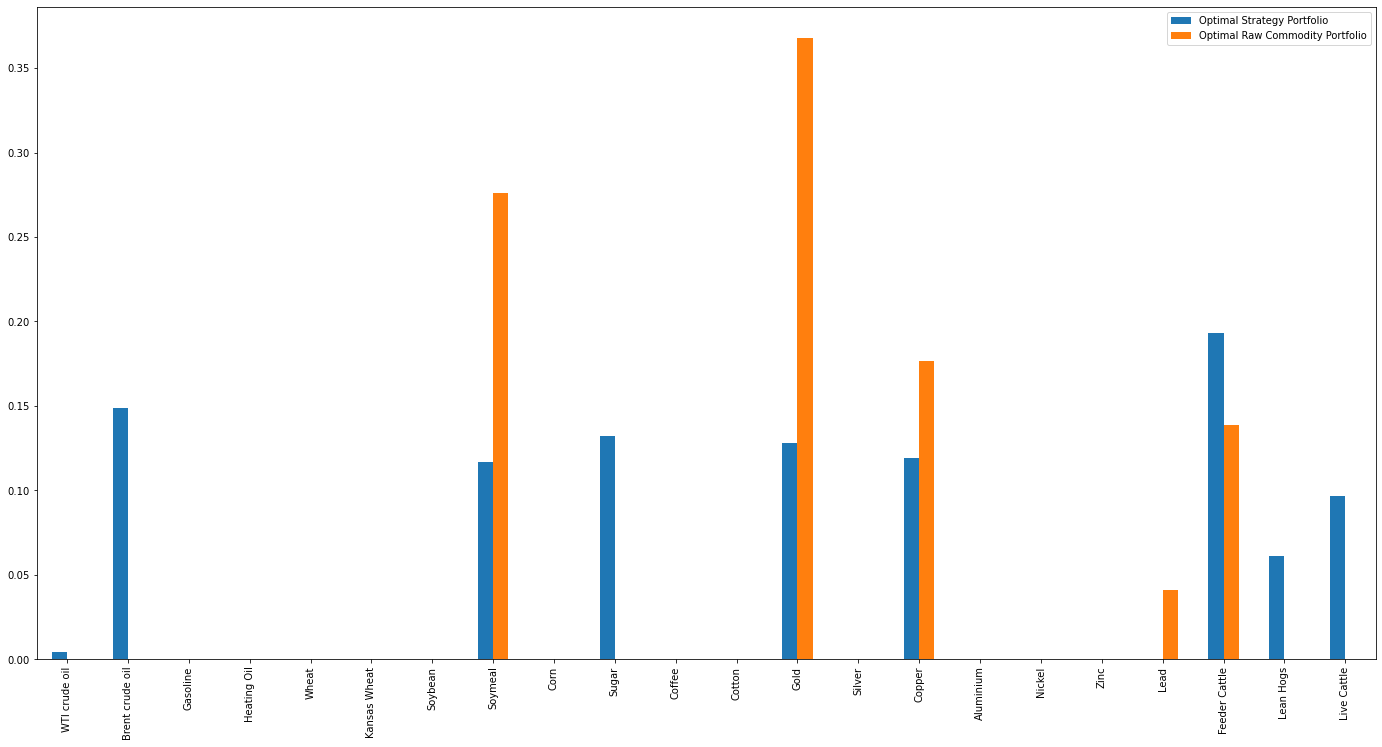

In [25]:
optPortWgt.plot.bar(figsize=(24,12))

Below are histograms of the two portfolios. Note the shift in skewness between the two distributions.

array([[<AxesSubplot:title={'center':'Optimal Strategy Portfolio'}>,
        <AxesSubplot:title={'center':'Optimal Raw Commodity Portfolio'}>]],
      dtype=object)

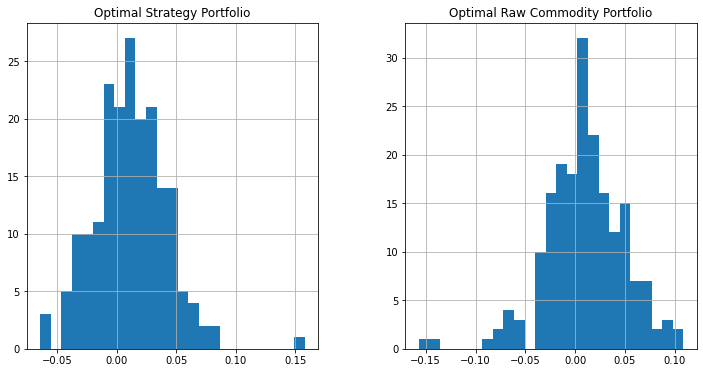

In [26]:
optPortMthRet.hist(bins=25, figsize=(12,6))

#### ENHANCEMENTS

The above strategy has many potential improvements. Below is a (non-exhaustive) list of things that can be done given more time and resources:
- Research and study as to the window length and weighting scheme to be used for the moving averages. For this exercise, window lengths of 10D (i.e. 2 weeks) and 45D (i.e. ~2 months) were chosen arbitrarily, while equal weights (rather than EWM) were used for simplicity.
- Accounting for transaction costs would be critical in order to better estimate the pnl of the strategy, but would also help dampen the sometimes chaotic signal (i.e. rapid changing of signs) the strategy is prone to.
- To further limit drawdown and improve the efficiency of the strategy, implementation of something similar to the triple barrier method could prove useful. This method sets bounds for strategy stop losses and profit taking (both when a certain price level has been hit or holding time reached).
- For the portfolio optimization part, the same assumption problems as talked about in question 1 apply. As such, it may be better to target the minimum variance portfolio rather than the max sharpe portfolio. In order to improve estimation of the covariance matrix, it would be best to denoise it with a method like Marcenko-Pastur.